In [18]:
# import libaries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests

In [2]:
# api keys

# omdb (open movie database). get a free api key here: https://www.omdbapi.com/
apikey_omdb = 'c733b530'


In [3]:
# json file of all star trek scripts can be found here: https://www.kaggle.com/gjbroughton/start-trek-scripts 

# read in the json file
df = pd.read_json('all_series_lines.json')

df.head()

,ENT,DS9,TOS,TAS,TNG,VOY
episode 0,"{'KLAANG': ['', '', 'Pung ghap! Pung ghap!', '...","{'JENNIFER': ['Hey!', 'Yes?', 'I'm sorry did w...","{'HASKINS': ['Doctor Theodore Haskins, America...","{'MCCOY': ['If its pull is this strong, Jim, h...","{'BAILIFF': ['The prisoners will all stand.', ...",{'JANEWAY': ['Tom Paris? Kathryn Janeway. I se...
episode 1,"{'KLAANG': [], 'DOCK': [], 'ARCHER': ['Come in...","{'JENNIFER': [], 'OPS': [], 'JASAD': [], 'PICA...","{'HASKINS': [], 'TALOSIAN': [], 'GEOLOGIST': [...","{'MCCOY': ['Who's he, Jim?', 'Afraid I don't, ...","{'BAILIFF': [], 'MCCOY': [], 'PICARD': ['Repor...",{'JANEWAY': ['What about alternative energy so...
episode 2,"{'KLAANG': [], 'DOCK': [], 'ARCHER': ['T'Pol.'...","{'JENNIFER': [], 'OPS': [], 'JASAD': [], 'PICA...","{'HASKINS': [], 'TALOSIAN': [], 'GEOLOGIST': [...","{'MCCOY': ['Jim, if we can't stop it, millions...","{'BAILIFF': [], 'MCCOY': [], 'PICARD': ['On ou...","{'JANEWAY': ['Report!', 'Mister Paris, can you..."
episode 3,"{'KLAANG': [], 'DOCK': [], 'ARCHER': ['Archer ...","{'JENNIFER': [], 'OPS': [], 'JASAD': [], 'PICA...","{'HASKINS': [], 'TALOSIAN': [], 'GEOLOGIST': [...","{'MCCOY': ['Magnolias in blossom. Beautiful.',...","{'BAILIFF': [], 'MCCOY': [], 'PICARD': ['Enlar...",{'JANEWAY': ['Assuming we do find dilithium on...
episode 4,"{'KLAANG': [], 'DOCK': [], 'ARCHER': ['Are we ...","{'JENNIFER': [], 'OPS': [], 'JASAD': [], 'PICA...","{'HASKINS': [], 'TALOSIAN': [], 'GEOLOGIST': [...","{'MCCOY': ['I don't want to think about it.', ...","{'BAILIFF': [], 'MCCOY': [], 'PICARD': ['I don...","{'JANEWAY': ['Personal log,Stardate 48546.2. O..."


In [4]:
# create list of episodes in ds9 series

ds9_episodes = df['DS9'].keys()

ds9_episodes

Index(['episode 0', 'episode 1', 'episode 2', 'episode 3', 'episode 4',
       'episode 5', 'episode 6', 'episode 7', 'episode 8', 'episode 9',
       ...
       'episode 166', 'episode 167', 'episode 168', 'episode 169',
       'episode 170', 'episode 171', 'episode 172', 'episode 173',
       'episode 174', 'episode 175'],
      dtype='object', length=176)

In [5]:
# count number of lines per character per episode and put in dataframe

episodes = []
characters = []
lines = []

for ep in np.arange(len(ds9_episodes)):

    if df['DS9'][ds9_episodes[ep]] is not np.NaN:
    
        for character in list(df['DS9'][ds9_episodes[ep]].keys()):
        
            line_count = len(df['DS9'][ds9_episodes[ep]][character])    
            
            episodes.append(ep)
            characters.append(character)
            lines.append(line_count)
            
df_ds9 = pd.DataFrame({'episode': episodes,
                       'character': characters,
                       'line_count': lines
                      })

df_ds9.head()

,episode,character,line_count
0,0,JENNIFER,41
1,0,OPS,4
2,0,JASAD,13
3,0,PICARD,28
4,0,MAGGIE,1


In [6]:
# do a little cleanup

# replace instances of 'DAX' with 'JADZIA'
df_ds9['character'] = df_ds9['character'].replace(['EZRI'],'DAX')

# clean up O'BRIEN names 
df_ds9['character'] = df_ds9['character'].replace(["youO'BRIEN", "wasO'BRIEN", "0'BRIEN"],"O'BRIEN")


# remove instances where line_count equals zero
df_ds9 = df_ds9[df_ds9['line_count'] != 0]

# add 1 to episode and change to string

df_ds9['seriesEpisode'] = df_ds9['episode'] + 1


In [7]:
# list out characters with most lines

top_characters = df_ds9.groupby('character')['line_count'].sum().sort_values(ascending=False).head(25)

top_characters

character
SISKO        8664
KIRA         5495
BASHIR       5151
O'BRIEN      4980
DAX          4896
ODO          4779
QUARK        4501
WORF         2085
JAKE         1612
GARAK        1492
NOG          1304
DUKAT        1279
ROM          1209
WEYOUN        555
WINN          520
KEIKO         494
MARTOK        482
DAMAR         433
KASIDY        372
VIC           357
ZEK           355
COMPUTER      341
BAREIL        311
EDDINGTON     300
FOUNDER       255
Name: line_count, dtype: int64

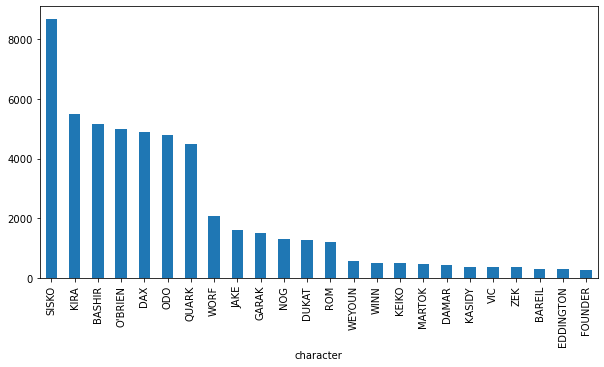

In [20]:
#top_characters_clean = top_characters[~top_characters.index.isin(['COMPUTER', 'ZEK', 'VIC', 'BAREIL', 'KASIDY', 'EDDINGTON', 'KEIKO', 'FOUNDER'])]
top_characters_clean = top_characters[~top_characters.index.isin(['COMPUTER'])]

fig, ax = plt.subplots(figsize=(10,5))
top_characters_clean.plot.bar();

In [21]:
url = 'http://www.omdbapi.com/'
title = 'deep+space+nine'

for season in np.arange(1,8):

    params = {'apikey': apikey_omdb,
              't': title,
              'season': season}

    response = requests.get(url, params)

    data = response.json()
    
    df_season = pd.DataFrame(data)
    
    if season == 1:
    
        df_omdb = df_season
    
    else:
        
        df_omdb = df_omdb.append(df_season)

df_omdb.reset_index(drop=True, inplace=True)


# split Episodes column in separate columns and put in dataframe

df_episodes = df_omdb['Episodes'].apply(pd.Series)

df_episodes


# rename show 'Title' as 'Series'
df_omdb = df_omdb.rename(columns={'Title': 'Series'})

df_omdb = df_omdb.join(df_episodes)

df_omdb["seriesEpisode"] = df_omdb.index + 1

df_omdb

,Series,Season,totalSeasons,Episodes,Response,Title,Released,Episode,imdbRating,imdbID,seriesEpisode
0,Star Trek: Deep Space Nine,1,7,"{'Title': 'Emissary', 'Released': '1993-01-03'...",True,Emissary,1993-01-03,1,7.6,tt0108214,1
1,Star Trek: Deep Space Nine,1,7,"{'Title': 'Past Prologue', 'Released': '1993-0...",True,Past Prologue,1993-01-10,2,7.1,tt0708576,2
2,Star Trek: Deep Space Nine,1,7,"{'Title': 'A Man Alone', 'Released': '1993-01-...",True,A Man Alone,1993-01-17,3,6.9,tt0708494,3
3,Star Trek: Deep Space Nine,1,7,"{'Title': 'Babel', 'Released': '1993-01-24', '...",True,Babel,1993-01-24,4,7.0,tt0708501,4
4,Star Trek: Deep Space Nine,1,7,"{'Title': 'Captive Pursuit', 'Released': '1993...",True,Captive Pursuit,1993-01-31,5,7.7,tt0708513,5
...,...,...,...,...,...,...,...,...,...,...,...
168,Star Trek: Deep Space Nine,7,7,"{'Title': 'When It Rains...', 'Released': '199...",True,When It Rains...,1999-05-05,21,8.3,tt0708663,169
169,Star Trek: Deep Space Nine,7,7,"{'Title': 'Tacking Into The Wind', 'Released':...",True,Tacking Into The Wind,1999-05-12,22,8.8,tt0708608,170
170,Star Trek: Deep Space Nine,7,7,"{'Title': 'Extreme Measures', 'Released': '199...",True,Extreme Measures,1999-05-19,23,7.8,tt0708535,171
171,Star Trek: Deep Space Nine,7,7,"{'Title': 'The Dogs Of War', 'Released': '1999...",True,The Dogs Of War,1999-05-26,24,8.4,tt0708622,172


In [22]:
df_merge = df_ds9.merge(df_omdb, on='seriesEpisode', how='inner')

df_merge.head()

,episode,character,line_count,seriesEpisode,Series,Season,totalSeasons,Episodes,Response,Title,Released,Episode,imdbRating,imdbID
0,0,JENNIFER,41,1,Star Trek: Deep Space Nine,1,7,"{'Title': 'Emissary', 'Released': '1993-01-03'...",True,Emissary,1993-01-03,1,7.6,tt0108214
1,0,OPS,4,1,Star Trek: Deep Space Nine,1,7,"{'Title': 'Emissary', 'Released': '1993-01-03'...",True,Emissary,1993-01-03,1,7.6,tt0108214
2,0,JASAD,13,1,Star Trek: Deep Space Nine,1,7,"{'Title': 'Emissary', 'Released': '1993-01-03'...",True,Emissary,1993-01-03,1,7.6,tt0108214
3,0,PICARD,28,1,Star Trek: Deep Space Nine,1,7,"{'Title': 'Emissary', 'Released': '1993-01-03'...",True,Emissary,1993-01-03,1,7.6,tt0108214
4,0,MAGGIE,1,1,Star Trek: Deep Space Nine,1,7,"{'Title': 'Emissary', 'Released': '1993-01-03'...",True,Emissary,1993-01-03,1,7.6,tt0108214


In [23]:
sum_lines_per_episode = df_merge.groupby('seriesEpisode')['line_count'].sum()

sum_lines_per_episode

seriesEpisode
1      664
2      419
3      389
4      399
5      355
      ... 
169    406
170    308
171    421
172    402
173    829
Name: line_count, Length: 173, dtype: int64

In [24]:
df_merge = df_merge.merge(sum_lines_per_episode, on='seriesEpisode', suffixes=('','_episode_total'))

df_merge

,episode,character,line_count,seriesEpisode,Series,Season,totalSeasons,Episodes,Response,Title,Released,Episode,imdbRating,imdbID,line_count_episode_total
0,0,JENNIFER,41,1,Star Trek: Deep Space Nine,1,7,"{'Title': 'Emissary', 'Released': '1993-01-03'...",True,Emissary,1993-01-03,1,7.6,tt0108214,664
1,0,OPS,4,1,Star Trek: Deep Space Nine,1,7,"{'Title': 'Emissary', 'Released': '1993-01-03'...",True,Emissary,1993-01-03,1,7.6,tt0108214,664
2,0,JASAD,13,1,Star Trek: Deep Space Nine,1,7,"{'Title': 'Emissary', 'Released': '1993-01-03'...",True,Emissary,1993-01-03,1,7.6,tt0108214,664
3,0,PICARD,28,1,Star Trek: Deep Space Nine,1,7,"{'Title': 'Emissary', 'Released': '1993-01-03'...",True,Emissary,1993-01-03,1,7.6,tt0108214,664
4,0,MAGGIE,1,1,Star Trek: Deep Space Nine,1,7,"{'Title': 'Emissary', 'Released': '1993-01-03'...",True,Emissary,1993-01-03,1,7.6,tt0108214,664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2871,172,BREEN,1,173,Star Trek: Deep Space Nine,7,7,"{'Title': 'What You Leave Behind', 'Released':...",True,What You Leave Behind,1999-06-02,25,9.0,tt0394907,829
2872,172,GOR,17,173,Star Trek: Deep Space Nine,7,7,"{'Title': 'What You Leave Behind', 'Released':...",True,What You Leave Behind,1999-06-02,25,9.0,tt0394907,829
2873,172,BROCA,17,173,Star Trek: Deep Space Nine,7,7,"{'Title': 'What You Leave Behind', 'Released':...",True,What You Leave Behind,1999-06-02,25,9.0,tt0394907,829
2874,172,EKOOR,7,173,Star Trek: Deep Space Nine,7,7,"{'Title': 'What You Leave Behind', 'Released':...",True,What You Leave Behind,1999-06-02,25,9.0,tt0394907,829


In [25]:
df_merge['episodeFraction'] = df_merge['line_count'] / df_merge['line_count_episode_total']

df_merge['ratingFraction'] = df_merge['episodeFraction'] * df_merge['imdbRating'].astype(float)

df_merge.head()

,episode,character,line_count,seriesEpisode,Series,Season,totalSeasons,Episodes,Response,Title,Released,Episode,imdbRating,imdbID,line_count_episode_total,episodeFraction,ratingFraction
0,0,JENNIFER,41,1,Star Trek: Deep Space Nine,1,7,"{'Title': 'Emissary', 'Released': '1993-01-03'...",True,Emissary,1993-01-03,1,7.6,tt0108214,664,0.061747,0.469277
1,0,OPS,4,1,Star Trek: Deep Space Nine,1,7,"{'Title': 'Emissary', 'Released': '1993-01-03'...",True,Emissary,1993-01-03,1,7.6,tt0108214,664,0.006024,0.045783
2,0,JASAD,13,1,Star Trek: Deep Space Nine,1,7,"{'Title': 'Emissary', 'Released': '1993-01-03'...",True,Emissary,1993-01-03,1,7.6,tt0108214,664,0.019578,0.148795
3,0,PICARD,28,1,Star Trek: Deep Space Nine,1,7,"{'Title': 'Emissary', 'Released': '1993-01-03'...",True,Emissary,1993-01-03,1,7.6,tt0108214,664,0.042169,0.320482
4,0,MAGGIE,1,1,Star Trek: Deep Space Nine,1,7,"{'Title': 'Emissary', 'Released': '1993-01-03'...",True,Emissary,1993-01-03,1,7.6,tt0108214,664,0.001506,0.011446


In [14]:
df_merge.to_csv('ds9_character_analysis.csv')

In [27]:
ratingPoints = df_merge.groupby('character')['ratingFraction'].sum()

ratingPoints

character
ADL        0.017955
ADMIRAL    0.125682
AFR        0.020944
AGENT      0.074109
AH-KEL     0.421186
             ...   
ZLANGCO    0.210471
ZOLAN      0.225337
ZYREE      0.281426
bat-LEH    0.020402
mat-LEH    0.020402
Name: ratingFraction, Length: 694, dtype: float64

In [28]:
episodes_count = df_merge.groupby('character')['seriesEpisode'].count()

episodes_count

character
ADL        1
ADMIRAL    1
AFR        1
AGENT      1
AH-KEL     1
          ..
ZLANGCO    1
ZOLAN      1
ZYREE      1
bat-LEH    1
mat-LEH    1
Name: seriesEpisode, Length: 694, dtype: int64

In [29]:
df_final = pd.concat([ratingPoints, episodes_count], axis=1)
df_final['score'] = df_final['ratingFraction'] / df_final['seriesEpisode']
df_final = df_final.sort_values(by='score', ascending=False)
df_final = df_final[df_final.index.isin(top_characters_clean.index)]
df_final

,ratingFraction,seriesEpisode,score
character,,,
SISKO,171.935553,173,0.993847
GARAK,32.381829,38,0.852153
VIC,6.754267,8,0.844283
DUKAT,27.755722,34,0.816345
WINN,10.819948,14,0.772853
ZEK,5.256719,7,0.750960
BAREIL,5.621845,8,0.702731
EDDINGTON,6.112309,9,0.679145
KIRA,109.467896,171,0.640163


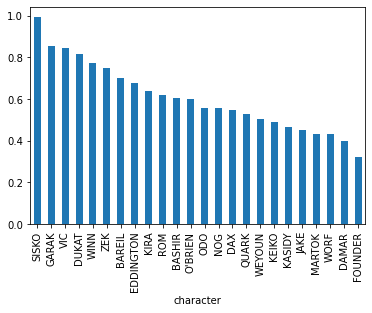

In [30]:
fig, ax = plt.subplots()

df_final['score'].plot.bar();

In [31]:
#best couples, thruples, and quadruples?

# sisko & dukat
# sisko & winn
# jake & nog
# garak & bashir
# obrien & bashir
# kira & dukat
# kira & odo
# dukat & winn
# quark, rom, and nog
# quark & odo
# worf & dax
# worf & martok
# weyoun & damar